In [29]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                      # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io

#Set default dtype to double
torch.set_default_dtype(torch.double)

#PyTorch random number generator
torch.manual_seed(1234)      

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cpu


In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 定义 Double Well Potential
def V(x, T):
    a = (1/6*0.06)*T
    b = (4.0*0.06)*T
    c = T*(24/5.5*(T-0.5)+12)*0.06
    return a * x**6 - b * x**4 + c * x**2

def boltzmann_probability(V,x_vals,T, kb=1):
    P = torch.exp(-V / (kb*T))  # Compute unnormalized probability
    P /= torch.trapz(P.squeeze(), x_vals.squeeze())  # Normalize
    return P


In [31]:
# 网络结构
import torch
import torch.nn as nn
import numpy as np

class Two_NN(nn.Module):
    def __init__(self,width):
        super().__init__()
        self.width = width
        self.fc1 = nn.Linear(2,width)
        self.fc2 = nn.Linear(width,1,bias=False)
        self.act1 = nn.ReLU()
        self.act2 = nn.Tanh()
    
    def forward(self,x):
        y = self.fc1(x)
        y = self.act2(y)
        y = self.fc2(y)

        return y

In [32]:
# Define CZ model
Nf=300
xmin = -6
xmax = 6
class CoupledModel(nn.Module):
    def __init__(self, width, num_networks=6, kb=1.0):
        super(CoupledModel, self).__init__()
        self.num_networks = num_networks
        self.sub_networks = nn.ModuleList([Two_NN(width) for _ in range(num_networks)])  # 6 个 Two_NN 子网络
        self.kb = kb  # Boltzmann 常数
    def forward(self, x):
        # 计算每对网络的未归一化输出
        T = x[:, 1].unsqueeze(1)  # Shape: [batch_size, 1]
        logits = []
        values = []
        for i in range(self.num_networks // 1):
            net1_out = self.sub_networks[1 * i](x)  # net(2i)
            logit = torch.exp(-(net1_out)/(self.kb*T))  # exp(-(net1 - T * net2)/(kb*T))
            value = net1_out  # net1 - T * net2
            logits.append(logit)
            values.append(value)

        logits = torch.cat(logits, dim=1)  # Shape [batch_size, 3]
        values = torch.cat(values, dim=1)  # Shape [batch_size, 3]

        # Softmax-like normalization
        softmax_weights = logits / torch.sum(logits, dim=1, keepdim=True)

        # Compute the first term: weighted sum of (net1 - T * net2)
        weighted_values = torch.sum(softmax_weights * values, dim=1, keepdim=True)

        # Compute the second term: weighted sum of log probabilities
        log_probs = torch.log(softmax_weights + 1e-9)  # Avoid log(0)
        weighted_log_probs = torch.sum(softmax_weights * log_probs, dim=1, keepdim=True)

        # Final output
        output = weighted_values + self.kb * T * weighted_log_probs
        #output = (1/self.dx)*torch.softmax(-output/(self.T*self.kb), dim=1)  # 确保预测值是概率分布
        
        return output


In [33]:
# 定义Jesen熵函数

class KLDivergenceLoss(nn.Module):
    def __init__(self, reduction='batchmean',kb=1.0,dx=((xmax-xmin)/Nf)):
        super(KLDivergenceLoss, self).__init__()
        self.reduction = reduction
        #self.T = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # 可训练参数 T
        self.kb = kb  # Boltzmann 常数
        self.dx = dx # step size
    def forward(self,x, y_pred, y_true):
        T = x[:, 1].unsqueeze(1)  # Shape: [batch_size, 1]
        y_pred = (1/self.dx)*torch.softmax(-y_pred/(T*self.kb), dim=0) # 确保预测值是概率分布
        y_pred = torch.clamp(y_pred, min=1e-9, max=100)  # 避免 log(0)
        y_true = torch.clamp(y_true, min=1e-9, max=100)  # 避免 log(0)
        kl_pt = torch.sum(y_true * torch.log(y_true / (0.5*(y_pred+y_true))), dim=0)  # D_KL(P || Q)
        kl_tp = torch.sum(y_pred * torch.log(y_pred / (0.5*(y_pred+y_true))), dim=0)  # D_KL(Q || P)
        return torch.mean(0.5 * (kl_pt + kl_tp)) if self.reduction == 'mean' else torch.sum(0.5 * (kl_pt + kl_tp))




In [34]:
# 生成训练数据
T = 6.0  # Scalar temperature
Nf=300
min = -6
max = 6
# Generate X_train
X_train = torch.linspace(min, max, Nf).unsqueeze(1)  # Shape: [100, 1]
# Create a `100x1` tensor of T values
T_tensor = torch.full((Nf, 1), T, dtype=torch.float64)
# Concatenate X_train and T to create a `100x2` tensor
X_T_train1 = torch.cat([X_train, T_tensor], dim=1)  # Shape: [100, 2]

X_train = np.linspace(min,max,Nf)  # 输入 x
X_train = torch.tensor(X_train.reshape(-1,1), dtype=torch.float64, device=device)
x_vals = torch.linspace(min,max,Nf)
V_vals = V(x_vals,T)
P_vals = boltzmann_probability(V_vals,x_vals, T)
y_train1 = P_vals.reshape(-1,1) # 目标值

T = 1.5  # Scalar temperature

# Generate X_train
X_train = torch.linspace(xmin, xmax, Nf).unsqueeze(1)  # Shape: [100, 1]
# Create a `100x1` tensor of T values
T_tensor = torch.full((Nf, 1), T, dtype=torch.float32)
# Concatenate X_train and T to create a `100x2` tensor
X_T_train2 = torch.cat([X_train, T_tensor], dim=1)  # Shape: [100, 2]

X_train = np.linspace(min,max,Nf)  # 输入 x
X_train = torch.tensor(X_train.reshape(-1,1), dtype=torch.float64, device=device)
x_vals = torch.linspace(min,max,Nf)
V_vals = V(x_vals,T)
P_vals = boltzmann_probability(V_vals,x_vals, T)
y_train2 = P_vals.reshape(-1,1) # 目标值

T = 2.0  # Scalar temperature

# Generate X_train
X_train = torch.linspace(xmin, xmax, Nf).unsqueeze(1)  # Shape: [100, 1]
# Create a `100x1` tensor of T values
T_tensor = torch.full((Nf, 1), T, dtype=torch.float32)
# Concatenate X_train and T to create a `100x2` tensor
X_T_train3 = torch.cat([X_train, T_tensor], dim=1)  # Shape: [100, 2]

X_train = np.linspace(min,max,Nf)  # 输入 x
X_train = torch.tensor(X_train.reshape(-1,1), dtype=torch.float64, device=device)
x_vals = torch.linspace(min,max,Nf)
V_vals = V(x_vals,T)
P_vals = boltzmann_probability(V_vals,x_vals, T)
y_train3 = P_vals.reshape(-1,1) # 目标值

T = 4.0  # Scalar temperature
# Generate X_train
X_train = torch.linspace(xmin, xmax, Nf).unsqueeze(1)  # Shape: [100, 1]
# Create a `100x1` tensor of T values
T_tensor = torch.full((Nf, 1), T, dtype=torch.float32)
# Concatenate X_train and T to create a `100x2` tensor
X_T_train4 = torch.cat([X_train, T_tensor], dim=1)  # Shape: [100, 2]

X_train = np.linspace(min,max,Nf)  # 输入 x
X_train = torch.tensor(X_train.reshape(-1,1), dtype=torch.float64, device=device)
x_vals = torch.linspace(min,max,Nf)
V_vals = V(x_vals,T)
P_vals = boltzmann_probability(V_vals,x_vals, T)
y_train4 = P_vals.reshape(-1,1) # 目标值

T = 0.5  # Scalar temperature
# Generate X_train
X_train = torch.linspace(xmin, xmax, Nf).unsqueeze(1)  # Shape: [100, 1]
# Create a `100x1` tensor of T values
T_tensor = torch.full((Nf, 1), T, dtype=torch.float32)
# Concatenate X_train and T to create a `100x2` tensor
X_T_train5 = torch.cat([X_train, T_tensor], dim=1)  # Shape: [100, 2]

X_train = np.linspace(min,max,Nf)  # 输入 x
X_train = torch.tensor(X_train.reshape(-1,1), dtype=torch.float64, device=device)
x_vals = torch.linspace(min,max,Nf)
V_vals = V(x_vals,T)
P_vals = boltzmann_probability(V_vals,x_vals, T)
y_train5 = P_vals.reshape(-1,1) # 目标值

T = 1.0  # Scalar temperature
# Generate X_train
X_train = torch.linspace(xmin, xmax, Nf).unsqueeze(1)  # Shape: [100, 1]
# Create a `100x1` tensor of T values
T_tensor = torch.full((Nf, 1), T, dtype=torch.float32)
# Concatenate X_train and T to create a `100x2` tensor
X_T_train6 = torch.cat([X_train, T_tensor], dim=1)  # Shape: [100, 2]

X_train = np.linspace(min,max,Nf)  # 输入 x
X_train = torch.tensor(X_train.reshape(-1,1), dtype=torch.float64, device=device)
x_vals = torch.linspace(min,max,Nf)
V_vals = V(x_vals,T)
P_vals = boltzmann_probability(V_vals,x_vals, T)
y_train6 = P_vals.reshape(-1,1) # 目标值

X_T_train = torch.cat([X_T_train1, X_T_train2,X_T_train3,X_T_train4, X_T_train5,X_T_train6], dim=0)

y_train = torch.cat([y_train1, y_train2,y_train3,y_train4, y_train5,y_train6], dim=0)



# Print Shape for Debugging
print("X_T_train shape:", X_T_train.shape)  # Expect (100, 2)
print(X_T_train[195:205])  # Print first few rows to check
print(y_train.shape)
print(y_train[195:205])  # Print first few rows to check


X_T_train shape: torch.Size([1800, 2])
tensor([[1.8261, 6.0000],
        [1.8662, 6.0000],
        [1.9064, 6.0000],
        [1.9465, 6.0000],
        [1.9866, 6.0000],
        [2.0268, 6.0000],
        [2.0669, 6.0000],
        [2.1070, 6.0000],
        [2.1472, 6.0000],
        [2.1873, 6.0000]])
torch.Size([1800, 1])
tensor([[0.0059],
        [0.0051],
        [0.0045],
        [0.0040],
        [0.0036],
        [0.0032],
        [0.0028],
        [0.0026],
        [0.0023],
        [0.0021]])


In [35]:


# 创建耦合模型
width = 4  # Two_NN 隐藏层宽度
model = CoupledModel(width).to(device)

# 创建优化器
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 定义损失函数
criterion = KLDivergenceLoss()

 #训练循环
num_epochs = 20000
for epoch in range(num_epochs):
    optimizer.zero_grad()  # 清空梯度
    y_pred = model(X_T_train)  # 前向传播
    loss = criterion(X_T_train,y_pred, y_train)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新参数

    if epoch % 200 == 0:
       print(f"Epoch [{epoch}/{num_epochs}] - Loss: {loss.item():.4f}")


Epoch [0/20000] - Loss: 45.5059
Epoch [200/20000] - Loss: 36.6896
Epoch [400/20000] - Loss: 29.1368
Epoch [600/20000] - Loss: 27.4703
Epoch [800/20000] - Loss: 26.5754
Epoch [1000/20000] - Loss: 25.9430
Epoch [1200/20000] - Loss: 25.5697
Epoch [1400/20000] - Loss: 25.3460
Epoch [1600/20000] - Loss: 25.2236
Epoch [1800/20000] - Loss: 25.1437
Epoch [2000/20000] - Loss: 25.0817
Epoch [2200/20000] - Loss: 25.0390
Epoch [2400/20000] - Loss: 25.0103
Epoch [2600/20000] - Loss: 24.9777
Epoch [2800/20000] - Loss: 24.9634
Epoch [3000/20000] - Loss: 24.9380
Epoch [3200/20000] - Loss: 24.9229
Epoch [3400/20000] - Loss: 24.9297
Epoch [3600/20000] - Loss: 24.9044
Epoch [3800/20000] - Loss: 24.8885
Epoch [4000/20000] - Loss: 24.8855
Epoch [4200/20000] - Loss: 24.8729
Epoch [4400/20000] - Loss: 24.8714
Epoch [4600/20000] - Loss: 24.8831
Epoch [4800/20000] - Loss: 24.8743
Epoch [5000/20000] - Loss: 24.8692
Epoch [5200/20000] - Loss: 24.8645
Epoch [5400/20000] - Loss: 24.8675
Epoch [5600/20000] - Loss: 

torch.Size([300, 2]) torch.Size([300, 1])


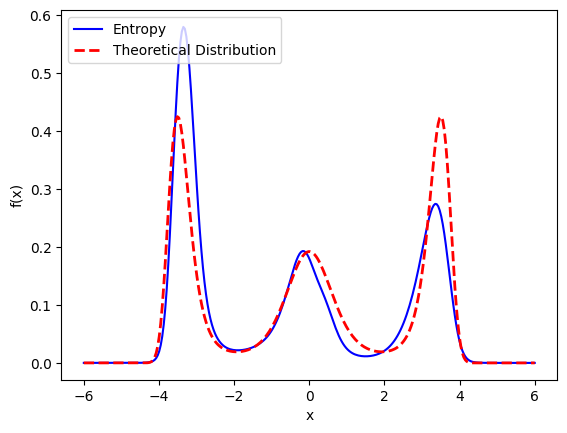

In [36]:
T=3.0
kb=1
X_train = torch.linspace(xmin, xmax, Nf).unsqueeze(1)  # Shape: [100, 1]
# Create a `100x1` tensor of T values
T_tensor = torch.full((Nf, 1), T, dtype=torch.float64)
# Concatenate X_train and T to create a `100x2` tensor
X_T_train = torch.cat([X_train, T_tensor], dim=1)  # Shape: [100, 2]

y_pred=model(X_T_train)
dx = (xmax-xmin)/Nf

y_pred = (1/dx)*torch.softmax(-y_pred/(kb*T), dim=0)
y = y_pred
print(X_T_train.shape,y.shape)
x = X_T_train[:,:-1]
# Plot the solutions
fig, ax1 = plt.subplots()
ax1.plot(x.cpu().detach().numpy(), y.cpu().detach().numpy(), color='blue', label='Entropy')  # Convert back to NumPy for plotting
x_vals = torch.linspace(-6, 6, 300)
# Compute potential values
V_vals = V(x_vals,T)
P_vals = boltzmann_probability(V_vals,x_vals, T)
P_vals = P_vals.detach().cpu().numpy()
plt.plot(x_vals, P_vals, 'r--', lw=2, label="Theoretical Distribution")  # 理论曲线

ax1.set_xlabel('x', color='black')
ax1.set_ylabel('f(x)', color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc='upper left')
plt.show()


In [37]:
import torch
import numpy as np

# Define constants
Tmin = 0.5
Tmax = 6.0
kb = 1
xmin, xmax, Nf ,NfT= -6, 6, 300,23

# Generate temperature values
T_values = torch.linspace(Tmin, Tmax, NfT)  # Shape: [100]

# Initialize list to store predictions
y_pred_list = []

for i in range(len(T_values)):  # ✅ Iterate over temperature indices
    # Generate X values
    X_train = torch.linspace(xmin, xmax, Nf).unsqueeze(1)  # Shape: [100, 1]

    # Create a `100x1` tensor of the current T value
    T_tensor = torch.full((Nf, 1), T_values[i].item(), dtype=torch.float64)

    # Concatenate X_train and T to create a `100x2` tensor
    X_T_train = torch.cat([X_train, T_tensor], dim=1)  # Shape: [100, 2]

    # Model prediction
    y_pred = model(X_T_train)  # Shape: [100, 1]

    # Compute normalized probability distribution
    dx = (xmax - xmin) / Nf
    y = (1 / dx) * torch.softmax(-y_pred / (kb * T_values[i]), dim=0)  # ✅ Fix: Use T_values[i]

    #  Store only `y` (not [y_pred, y])
    y_pred_list.append(y)  # Shape: [100, 1]

# Concatenate results after the loop
y_pred_final = torch.cat(y_pred_list, dim=1)  # Shape: [Nf,Nf]

# Convert to NumPy for saving
y_pred_np = y_pred_final.detach().cpu().numpy()

# Save to text file
np.savetxt("CE_y_pred_triple_T7.txt", y_pred_np, fmt="%.6f")

# Print shape confirmation
print(" y_pred saved successfully! Shape:", y_pred_np.shape)


 y_pred saved successfully! Shape: (300, 23)
